In [119]:
from PCA2D import PCA2D
import cv2
from imutils import paths
import plotly.graph_objects as go
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from scipy.fftpack import dct, idct
from PCA2D import PCA2D
import os

In [2]:
def cv_disp_img(img, title="image"):
    while True:
        cv2.imshow(title, img)
        k = cv2.waitKey(1)

        if k & 0xFF == ord('q'):
            # q key pressed so quit
            print("Quitting...")
            break

    cv2.destroyAllWindows()
    cv2.waitKey(1)

In [3]:
# implement 2D DCT
def dct2(a):
    return dct(dct(a.T, norm='ortho').T, norm='ortho')

# implement 2D IDCT
def idct2(a):
    return idct(idct(a.T, norm='ortho').T, norm='ortho') 

def dct_compression(img):
    imf = np.float32(img)
    comp = dct2(imf)/255. # Scale to force low values to 0
    comp = np.uint8(idct2(comp)*255)
    return comp

In [4]:

# Generate Dataset Matrix & Normalize/DCT
width = height = 300
size = (width * height)
imagePaths = list(paths.list_images("./Dataset/Train/"))

image_mat = np.zeros((len(imagePaths), height,width,3),dtype=np.uint8)

for ct, image in enumerate(imagePaths):
    img = cv2.imread(image)
    scaled = cv2.resize(img, (width, height), interpolation=cv2.INTER_LINEAR)
    norm_img = np.zeros((width, height))
    norm_img = cv2.normalize(scaled, norm_img, 0, 255, cv2.NORM_MINMAX)
    dct_img = dct_compression(norm_img)
    image_mat[ct, :, :, :] = cv2.cvtColor(dct_img, cv2.COLOR_BGR2RGB)

# image_mat = image_mat.reshape(image_mat.shape + (1,))
image_mat.shape

(91, 300, 300, 3)

In [5]:
# def image_to_feature_vector(image):
#     return np.uint8(image).flatten()

labels = []

for (i, imagePath) in enumerate(imagePaths):
    label = imagePath.split(os.path.sep)[-1].split(".")[0]
    labels.append(label)

In [6]:
orig_labels = labels
le = LabelEncoder()
labels = le.fit_transform(labels)
num_labels=labels
print(orig_labels, labels)

['Dad', 'Dad', 'Mom', 'Connor', 'Connor', 'Mom', 'Dad', 'Dad', 'Dad', 'Mom', 'Connor', 'Connor', 'Mom', 'Dad', 'Connor', 'Mom', 'Connor', 'Dad', 'Dad', 'Connor', 'Mom', 'Connor', 'Connor', 'Mom', 'Dad', 'Dad', 'Mom', 'Connor', 'Maddie', 'Mom', 'Maddie', 'Maddie', 'Mom', 'Maddie', 'Maddie', 'Maddie', 'Maddie', 'Maddie', 'Connor', 'Maddie', 'Maddie', 'Connor', 'Maddie', 'Maddie', 'Maddie', 'Maddie', 'Connor', 'Connor', 'Mom', 'Connor', 'Connor', 'Mom', 'Mom', 'Maddie', 'Connor', 'Connor', 'Mom', 'Mom', 'Connor', 'Connor', 'Mom', 'Dad', 'Connor', 'Connor', 'Connor', 'Connor', 'Dad', 'Dad', 'Mom', 'Connor', 'Connor', 'Connor', 'Connor', 'Connor', 'Connor', 'Mom', 'Dad', 'Dad', 'Mom', 'Connor', 'Connor', 'Mom', 'Dad', 'Dad', 'Mom', 'Connor', 'Dad', 'Dad', 'Connor', 'Mom', 'Dad'] [1 1 3 0 0 3 1 1 1 3 0 0 3 1 0 3 0 1 1 0 3 0 0 3 1 1 3 0 2 3 2 2 3 2 2 2 2
 2 0 2 2 0 2 2 2 2 0 0 3 0 0 3 3 2 0 0 3 3 0 0 3 1 0 0 0 0 1 1 3 0 0 0 0 0
 0 3 1 1 3 0 0 3 1 1 3 0 1 1 0 3 1]


In [7]:
# data = np.array(data) / 255.0
labels = np.uint8(np_utils.to_categorical(labels, 4))
print(labels[:5])

[[0 1 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [1 0 0 0]
 [1 0 0 0]]


In [8]:
(trainData, testData, trainLabels, testLabels) = train_test_split(
    image_mat, labels, test_size=.25, random_state=42)
X_train = trainData
y_train = trainLabels
X_val = testData
y_val = testLabels
n_input = trainData.shape[1]
n_class = trainLabels.shape[1]
X_val.shape,y_val.shape,X_train.shape,y_train.shape

((23, 300, 300, 3), (23, 4), (68, 300, 300, 3), (68, 4))

In [9]:
batch = X_train.shape[0]
batch

68

In [10]:
datagen = ImageDataGenerator(
    rotation_range=20,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         brightness_range=[-.5,.5],
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    dtype = np.uint8,
    fill_mode='nearest')

datagen.fit(X_train)
epochs = 10
data = np.zeros((1,300,300,3))
labels = np.zeros((1,4))
for e in range(epochs):
    print('Epoch', e)
    batches = 0
    for x_batch, y_batch in datagen.flow(X_train, y_train, batch_size=batch):
        data = np.concatenate((data,x_batch),axis=0)
        labels = np.concatenate((labels,y_batch),axis=0)
#         model.fit(x_batch, y_batch)
        batches += 1
        if batches >= len(X_train) / batch:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


In [11]:
for i,img in enumerate(x_batch):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = np.uint8(img)
    cv2.imwrite(f"preview/test_{i}.png", img)

In [12]:
data.shape,labels.shape

((681, 300, 300, 3), (681, 4))

In [13]:
data = np.uint8(data[1:])
labels = np.uint8(labels[1:])

gray = np.zeros((data.shape[:3]))

for ct, img in enumerate(data):
    gray[ct] = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
gray = np.uint8(gray)

In [14]:
gray.shape,labels.shape

((680, 300, 300), (680, 4))

In [15]:
test_idx = 643 # must be greater than 612 since test dir only has last batch of 68 images (in this case)
cv_disp_img(gray[test_idx]) # should match preview/test_{test_idx-612}.png 

Quitting...


In [16]:
pca = PCA2D(gray,d=15,q=15)
Y, X, G = pca.reduce_dim_row()
B, Z, H = pca.reduce_dim_col()
C, X2, Z2 = pca.reduce_dim_square()

In [17]:
cv_disp_img(np.uint8(Z2 @ C[test_idx] @ X2.T))

Quitting...


In [48]:
horiz = []
num = 0
for ct, label in enumerate(labels):
    if (label == [1, 0, 0, 0]).all():
        if num <= 5:
            original = gray[ct]
            original_scaled = cv2.resize(original, (height,width), interpolation=cv2.INTER_LINEAR)
            
            rowPCA = np.uint8(Y[ct] @ X.T)
            colPCA = np.uint8(Z @ B[ct])
            
            sqrPCA = np.uint8(Z @ C[ct] @ X.T)
            sqrPCA = cv2.resize(sqrPCA, (height,width), interpolation=cv2.INTER_LINEAR)
            
            featMat = cv2.resize(np.uint8(C[ct]), (height,width), interpolation=cv2.INTER_LINEAR)
        
            horiz += [cv2.hconcat((original_scaled,rowPCA,colPCA,sqrPCA,featMat))]
        num += 1

cv_disp_img(cv2.vconcat(tuple(horiz)))

Quitting...


In [19]:
np.save("./PP_Data/C.npy", C)
np.save("./PP_Data/X.npy", X2)
np.save("./PP_Data/Z.npy", Z2)

In [20]:
features = []

for i in range(gray.shape[0]):
    features.append(C[i].flatten())

In [21]:
features = np.array(features) # NORMALIZE?? does good without it rn

In [22]:
labels.shape,features.shape

((680, 4), (680, 225))

In [23]:
np.save("./PP_Data/features.npy", features)
np.save("./PP_Data/labels.npy", labels)

In [24]:
X_val.shape, y_val.shape

((23, 300, 300, 3), (23, 4))

In [27]:
test_gray = np.zeros((X_val.shape[:3]))

for ct, img in enumerate(X_val):
    test_gray[ct] = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY) # RGB OR BGR CHECK!!!!!!!
    
test_gray = np.uint8(test_gray)

In [37]:
test_features = []

for i in range(test_gray.shape[0]):
    test_C = Z2.T @ test_gray[i] @ X2
    test_features.append(test_C.flatten())ß

test_features = np.array(test_features) # NORMALIZE?? does good without it rn

In [38]:
test_features.shape

(23, 225)

In [39]:
np.save("./PP_Data/test_features.npy", test_features)
np.save("./PP_Data/test_labels.npy", y_val)

In [49]:
pca_row,_,_ = PCA2D(gray,d=2,q=1).reduce_dim_square()
pca_col,_,_ = PCA2D(gray,d=1,q=2).reduce_dim_square()

In [51]:
pca_row.shape, pca_col.shape

((680, 1, 2), (680, 2, 1))

In [130]:
connor_row = pca_row[np.where(labels[:,0]==1)][:,0,:].T
dad_row = pca_row[np.where(labels[:,1]==1)][:,0,:].T
maddie_row = pca_row[np.where(labels[:,2]==1)][:,0,:].T
mom_row = pca_row[np.where(labels[:,3]==1)][:,0,:].T

In [131]:
connor_col = pca_col[np.where(labels[:,0]==1)][:,:,0].T
dad_col = pca_col[np.where(labels[:,1]==1)][:,:,0].T
maddie_col = pca_col[np.where(labels[:,2]==1)][:,:,0].T
mom_col = pca_col[np.where(labels[:,3]==1)][:,:,0].T

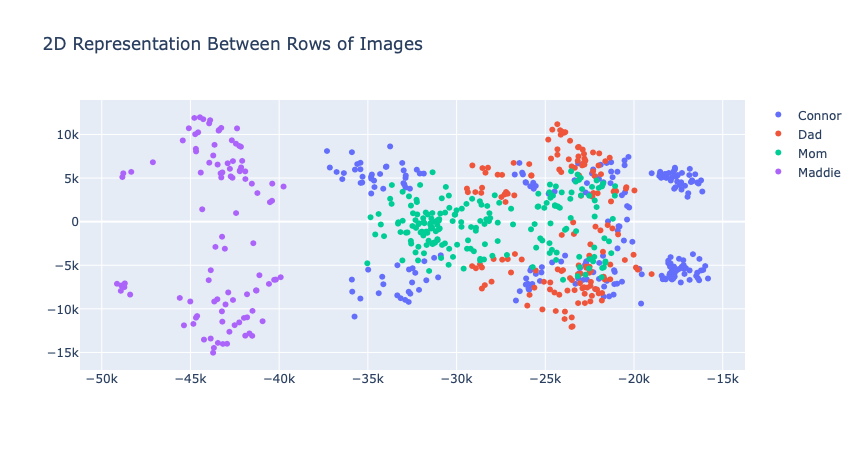

In [132]:
fig_row = go.Figure([go.Scatter(x=connor_row[0,:],y=connor_row[1,:],mode='markers',name="Connor")])
fig_row.add_trace(go.Scatter(x=dad_row[0,:],y=dad_row[1,:],mode='markers',name="Dad"))
fig_row.add_trace(go.Scatter(x=mom_row[0,:],y=mom_row[1,:],mode='markers',name="Mom"))
fig_row.add_trace(go.Scatter(x=maddie_row[0,:],y=maddie_row[1,:],mode='markers',name="Maddie"))
fig_row.update_layout(title="2D Representation Between Rows of Images")

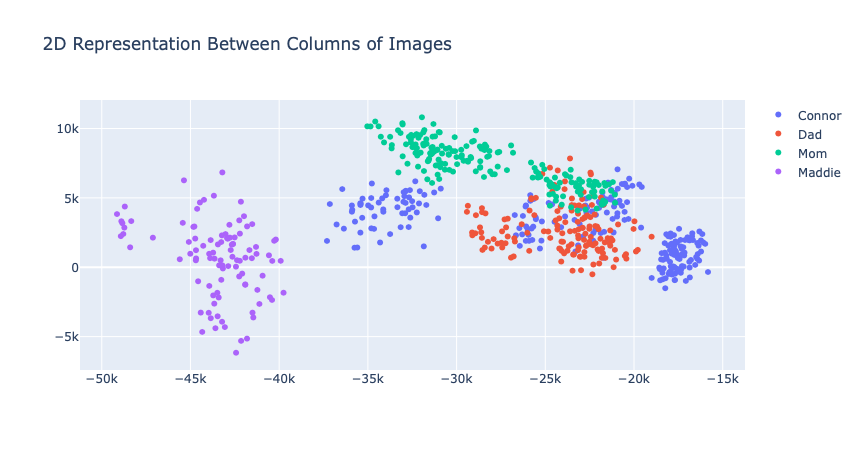

In [133]:
fig_col = go.Figure([go.Scatter(x=connor_col[0,:],y=connor_col[1,:],mode='markers',name="Connor")])
fig_col.add_trace(go.Scatter(x=dad_col[0,:],y=dad_col[1,:],mode='markers',name="Dad"))
fig_col.add_trace(go.Scatter(x=mom_col[0,:],y=mom_col[1,:],mode='markers',name="Mom"))
fig_col.add_trace(go.Scatter(x=maddie_col[0,:],y=maddie_col[1,:],mode='markers',name="Maddie"))
fig_col.update_layout(title="2D Representation Between Columns of Images")